In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_path = "/kaggle/input/thesis-datasetv2/Lung X-Ray Image/Lung X-Ray Image"

output_path = "Lung_XRay_Split"
os.makedirs(output_path, exist_ok=True)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        
        train_images, temp_images = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)
        
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'train', class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'val', class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'test', class_name, img))

print("Data split completed!")


Data split completed!


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMG_SIZE = (224, 224)  # Resize for models
BATCH_SIZE = 32

# Define data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  
)

train_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  
)


val_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' 
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1946 images belonging to 3 classes.
Found 484 images belonging to 3 classes.
Found 350 images belonging to 3 classes.


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3  
EPOCHS = 10

In [6]:

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1946 images belonging to 3 classes.
Found 484 images belonging to 3 classes.


In [7]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# This code unfreezes the last 40 (out of 315) layers of base_model, allowing them to be trainable for fine-tuning while keeping the earlier layers frozen.

In [8]:
# Unfreeze Top Layers for Fine-Tuning
for layer in base_model.layers[-40:]:  # Unfreeze the last 50 layers
    layer.trainable = True

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

In [19]:
# Unfreeze the last 40 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Calculate trainable parameters in the last 40 layers
trainable_params = 0
for layer in base_model.layers[-40:]:
    if hasattr(layer, 'trainable_weights') and layer.trainable_weights:
        for weight in layer.trainable_weights:
            trainable_params += np.prod(weight.shape)

print("Trainable parameters in the last 40 layers:", trainable_params)

Trainable parameters in the last 40 layers: 6073728


In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.6606 - loss: 0.7522 - val_accuracy: 0.8326 - val_loss: 0.5706
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.8847 - loss: 0.3077 - val_accuracy: 0.8099 - val_loss: 0.5132
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.9193 - loss: 0.2333 - val_accuracy: 0.9008 - val_loss: 0.2784
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - accuracy: 0.9240 - loss: 0.2094 - val_accuracy: 0.9277 - val_loss: 0.2019
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.9331 - loss: 0.1864 - val_accuracy: 0.8430 - val_loss: 0.3857
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.9450 - loss: 0.1588 - val_accuracy: 0.9174 - val_loss: 0.2295
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.9552 - loss: 0.1392 - val_accuracy: 0.8967 - val_loss: 0.3382
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.9557 - loss: 0.1132 - val_accuracy: 0.9050 

In [16]:
print("Feature Vector Shape:", feature_extractor.output_shape)

Feature Vector Shape: (None, 256)


In [12]:
feature_extractor.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,327,328 (85.17 MB)

 Trainable params: 22,292,896 (85.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [13]:
def extract_features(generator):
    features, labels = [], []
    for _ in range(len(generator)):
        X_batch, y_batch = next(generator)
        batch_features = feature_extractor.predict(X_batch)
        features.extend(batch_features)
        labels.extend(np.argmax(y_batch, axis=1))
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


Training SVM...
SVM Test Accuracy: 96.28%

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        76
           1       0.94      0.95      0.95        84
           2       0.98      1.00      0.99        82

    accuracy                           0.96       242
   macro avg       0.96      0.96      0.96       242
weighted avg       0.96      0.96      0.96       242



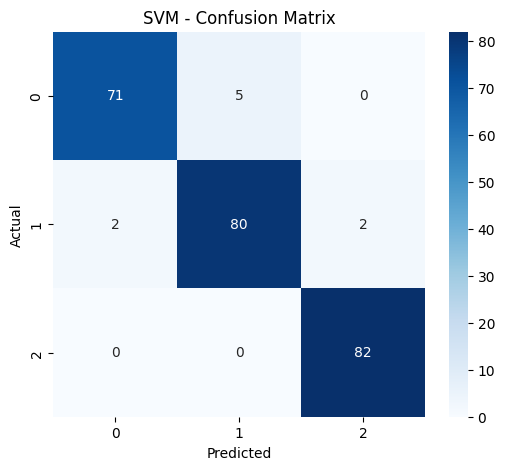

Training Random Forest...
Random Forest Test Accuracy: 94.21%

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        76
           1       0.92      0.93      0.92        84
           2       0.98      0.99      0.98        82

    accuracy                           0.94       242
   macro avg       0.94      0.94      0.94       242
weighted avg       0.94      0.94      0.94       242



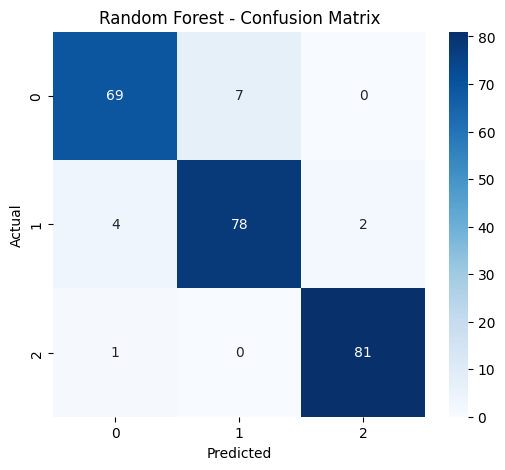

Training XGBoost...
XGBoost Test Accuracy: 94.63%

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        76
           1       0.93      0.93      0.93        84
           2       0.99      0.99      0.99        82

    accuracy                           0.95       242
   macro avg       0.95      0.95      0.95       242
weighted avg       0.95      0.95      0.95       242



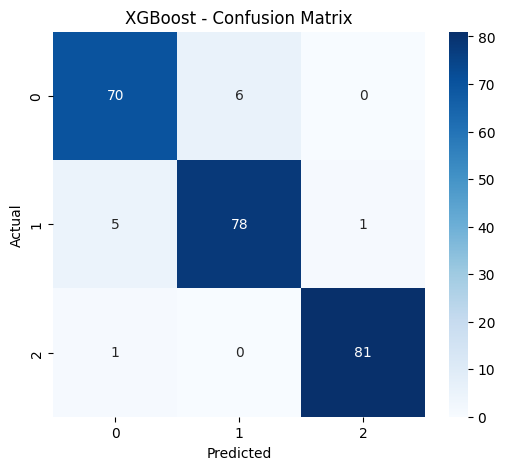

In [15]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    print(f"{name} Test Accuracy: {acc:.2f}%\n")
    print(classification_report(y_test, y_pred))
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()